In [1]:
# Custom Params
IMAGE_SIZE = (128, 128)
TEST_DATA_SIZE = 0.2
DROPOUT_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [2]:
# # Custom Params
# IMAGE_SIZE = (128, 128)
# TEST_DATA_SIZE = 0.2
# DROPOUT_RATIO = 0.2
# BATCH_SIZE = 128
# EPOCHS = 2

# Data Loading

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Path to the dataset
data_dir = '/kaggle/input/plantdisease/PlantVillage'

# Classes (labels) based on folder names in the dataset
classes = [plant for plant in os.listdir("/kaggle/input/plantdisease/PlantVillage") if plant.startswith("Tomato")]
print(classes)

# Mapper dictionary
class_mapper = {
    'Tomato_Leaf_Mold': 'Leaf Mold',
    'Tomato__Tomato_YellowLeaf__Curl_Virus': 'Yellow Leaf Curl Virus',
    'Tomato_Bacterial_spot': 'Bacterial Spot',
    'Tomato_Septoria_leaf_spot': 'Septoria Leaf Spot',
    'Tomato_healthy': 'Healthy',
    'Tomato_Spider_mites_Two_spotted_spider_mite': 'Spider Mites',
    'Tomato_Early_blight': 'Early Blight',
    'Tomato__Target_Spot': 'Target Spot',
    'Tomato_Late_blight': 'Late Blight',
    'Tomato__Tomato_mosaic_virus': 'Mosaic Virus'
}

['Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Tomato_Late_blight', 'Tomato__Tomato_mosaic_virus']


In [4]:
X = []
y = []

for label, class_name in tqdm(enumerate(classes)):
    class_dir = os.path.join(data_dir, class_name)
    label_name = class_mapper[class_name]
    
    if not os.path.isdir(class_dir):
        continue
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMAGE_SIZE)           # Resize image: Preprocessing
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB: Preprocessing
            X.append(img)
            y.append(label_name)

# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data loaded successfully: {X.shape[0]} images with size {X.shape[1:]}")

10it [01:51, 11.18s/it]


Data loaded successfully: 16011 images with size (128, 128, 3)


# Data Exploration

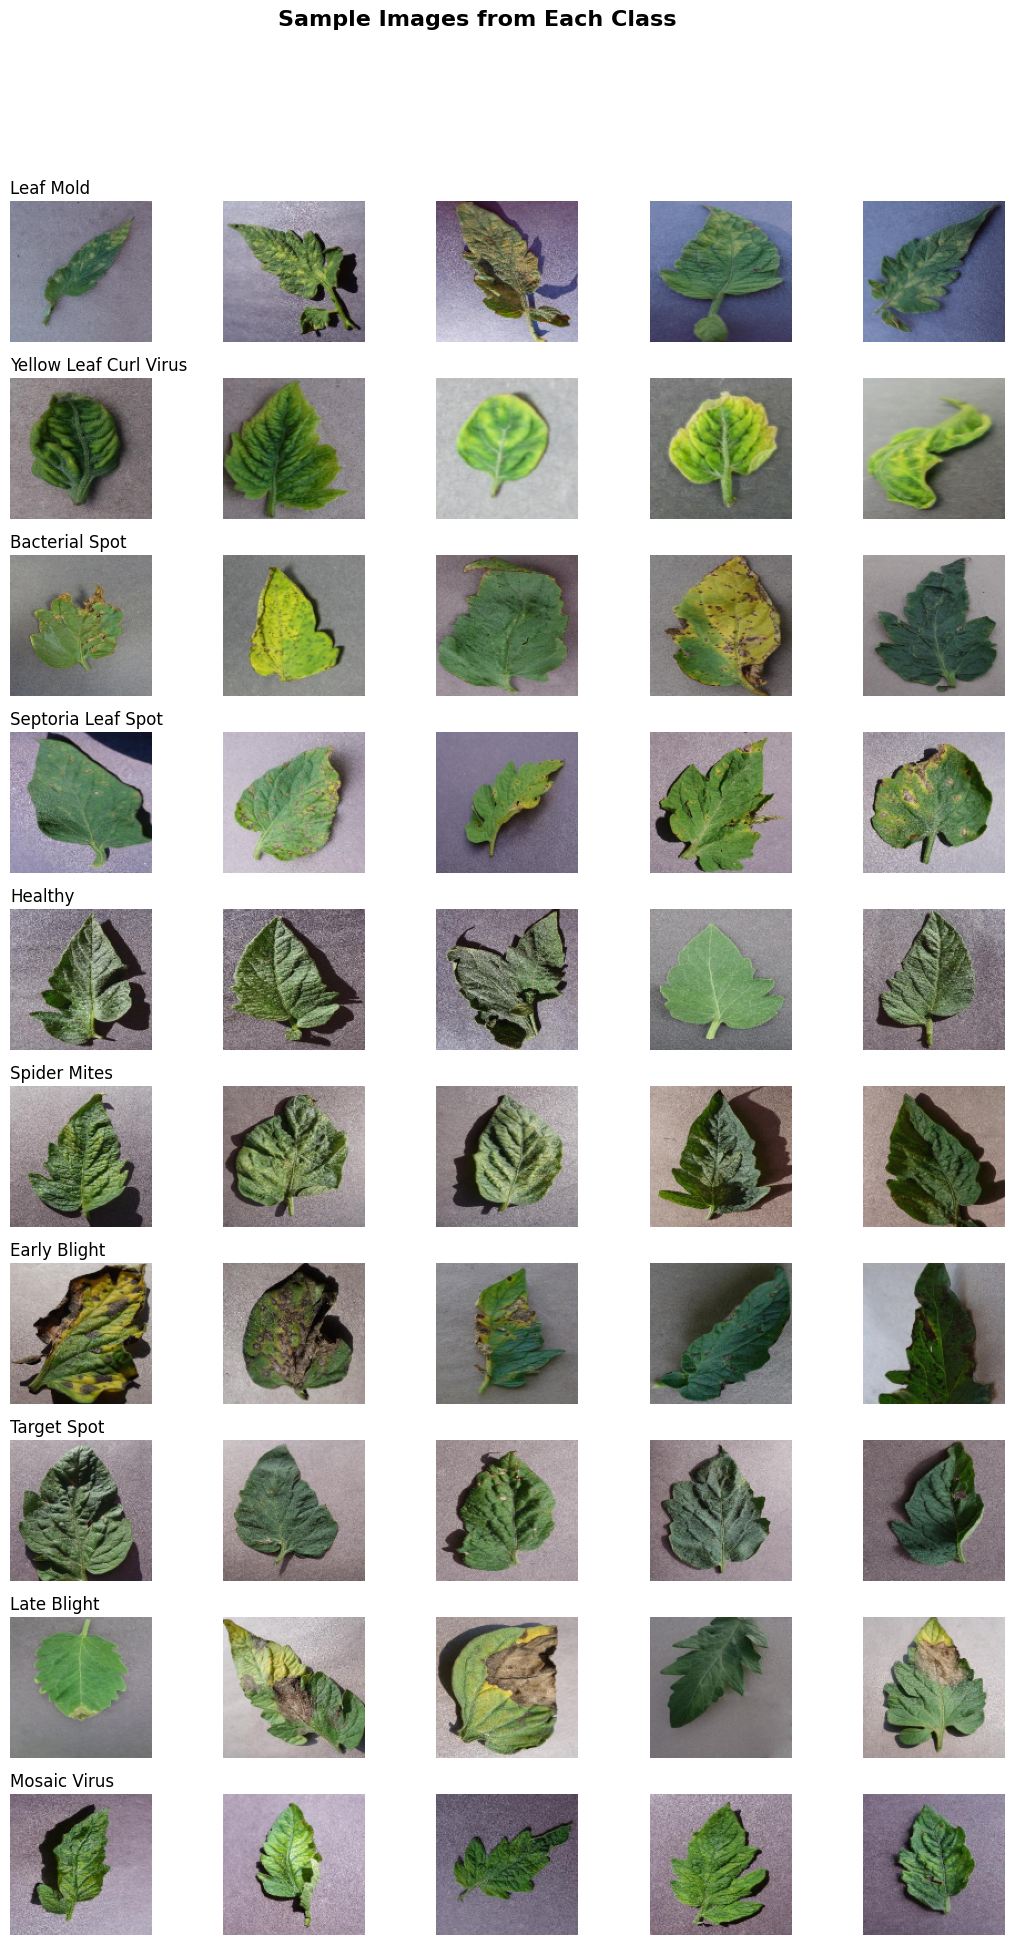

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

samples_per_class = 5
fig, axes = plt.subplots(len(class_mapper), samples_per_class, figsize=(12, len(class_mapper) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16, weight='bold', y=1.02)

# Indices by class for easy access
class_indices = defaultdict(list)
for idx, label in enumerate(y):
    class_indices[label].append(idx)

# Display images
for class_idx, (class_name, indices) in enumerate(class_indices.items()):
    selected_indices = np.random.choice(indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X[idx])
        ax.axis("off")

    # Label as a title for each row
    axes[class_idx, 0].set_title(class_name, fontsize=12, loc='left', pad=5)

# Adjusting layout for better spacing
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
plt.show()

Classes Distribution: 
 Counter({'Yellow Leaf Curl Virus': 3208, 'Bacterial Spot': 2127, 'Late Blight': 1909, 'Septoria Leaf Spot': 1771, 'Spider Mites': 1676, 'Healthy': 1591, 'Target Spot': 1404, 'Early Blight': 1000, 'Leaf Mold': 952, 'Mosaic Virus': 373})


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


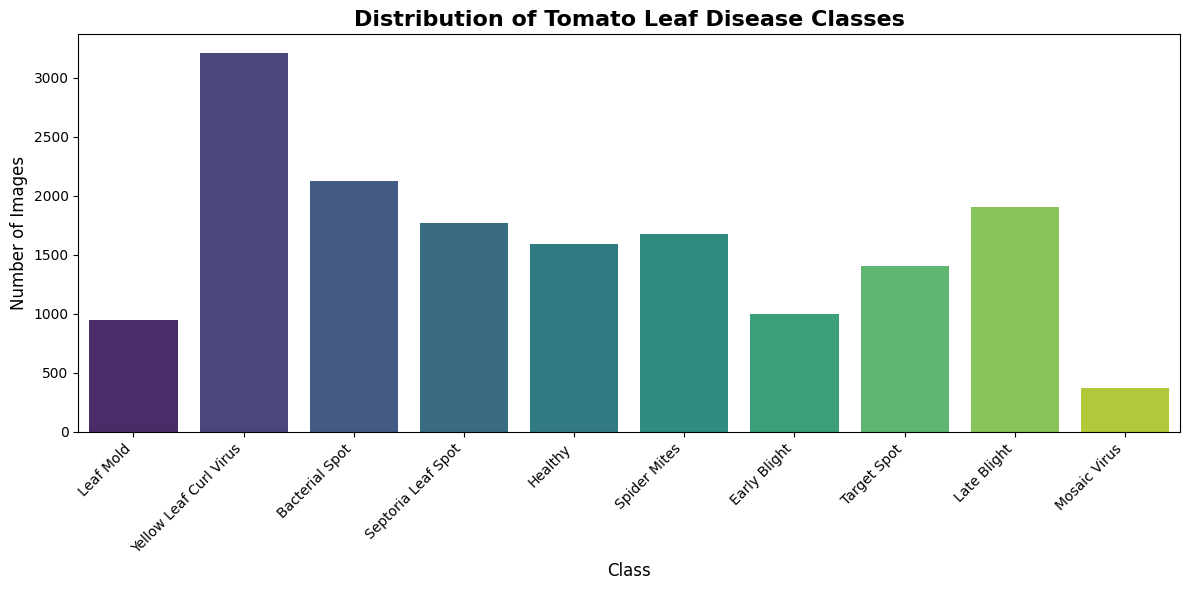

In [6]:
import seaborn as sns
from collections import Counter

# Occurrences of each class in y
class_counts = Counter(y)

print("Classes Distribution: \n", class_counts)

# Extracting class names and counts for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")

# Add titles and labels
plt.title("Distribution of Tomato Leaf Disease Classes", fontsize=16, weight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Encoding y
y_encoded = [classes.index(i) for i in y]

# Spliting data into 80% training and 20% testing: Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=TEST_DATA_SIZE, 
                                                    stratify=y, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,              # Normalize images: Preprocessing
    
    rotation_range=20,              # Rotate images up to 20 degrees
    width_shift_range=0.1,          # Shift images horizontally by 10%
    height_shift_range=0.1,         # Shift images vertically by 10%
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in on images
    horizontal_flip=True,           # Randomly flip images horizontally
    fill_mode='nearest'             # Fill pixels created by transformation
)

# Generator for test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Training generator
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,        # Grouping: Preprocessing
    shuffle=True                  # Shuffle the data
)

# Testing generator
test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Summary
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 12808, Testing samples: 3203


# CNN Model

In [9]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer with units equal to the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Path to save the best model
checkpoint_path = "best_model_cnn.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [11]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1735821714.640234      69 service.cc:145] XLA service 0x7bf9440043d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735821714.640298      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/400 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.0712 - loss: 2.4926

I0000 00:00:1735821718.769040      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/400 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.2947 - loss: 1.9584

I0000 00:00:1735821743.833289      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 64 bytes spill stores, 64 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3743 - loss: 1.7514
Epoch 1: val_loss improved from inf to 0.64347, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.3747 - loss: 1.7504 - val_accuracy: 0.7953 - val_loss: 0.6435
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6562 - loss: 1.0165

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.64347
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6562 - loss: 1.0165 - val_accuracy: 0.3333 - val_loss: 2.1857
Epoch 3/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7274 - loss: 0.7938
Epoch 3: val_loss improved from 0.64347 to 0.59725, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - accuracy: 0.7275 - loss: 0.7934 - val_accuracy: 0.7887 - val_loss: 0.5972
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8438 - loss: 0.5056
Epoch 4: val_loss improved from 0.59725 to 0.35401, saving model to best_model_cnn.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.8438 - loss: 0.5056 - val_accuracy: 1.0000 - val_loss: 0.3540
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8069 - loss: 0.5571
Epoch 5: val_loss did not improve from 0.35401
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.8069 - loss: 0.5570 - val_accuracy: 0.7959 - val

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import random

def evaluate_model(y_true, y_pred, class_names, images):
    # Calculate and print accuracy, precision, recall, F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # ROC Curve for each class
    plt.figure(figsize=(10, 7))
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=len(class_names))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title("ROC Curve for Each Class")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    
    # Display 3x3 grid of random samples with actual and predicted labels
    plt.figure(figsize=(8, 8))
    indices = random.sample(range(len(images)), 9)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        actual_label = class_names[y_true[idx]]
        predicted_label = class_names[y_pred[idx]]
        ax.set_title(f"Act: {actual_label}\nPred: {predicted_label}")
        plt.axis("off")
    plt.suptitle("3x3 Random Samples with Actual and Predicted Labels", fontsize=16)
    plt.tight_layout()
    plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.88

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.95      0.78      0.86       190
Yellow Leaf Curl Virus       0.97      0.96      0.96       642
        Bacterial Spot       0.99      0.89      0.94       426
    Septoria Leaf Spot       0.86      0.92      0.89       354
               Healthy       0.84      0.99      0.91       318
          Spider Mites       0.86      0.76      0.81       335
          Early Blight       0.82      0.69      0.75       200
           Target Spot       0.70      0.88      0.78       281
           Late Blight       0.93      0.86      0.90       382
          Mosaic Virus       0.70      0.99      0.82        75

              accuracy                           0.88      3203
             macro avg       0.86      0.87      0.86      3203
          weighted avg       0.89      0.8

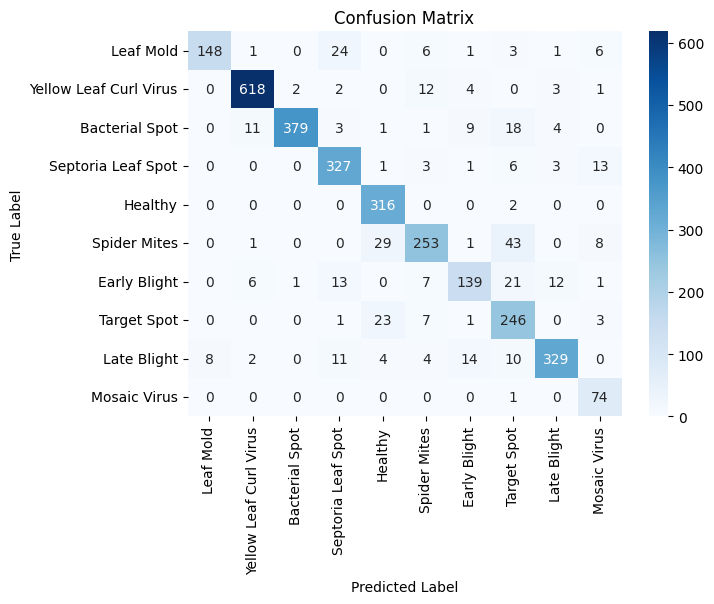

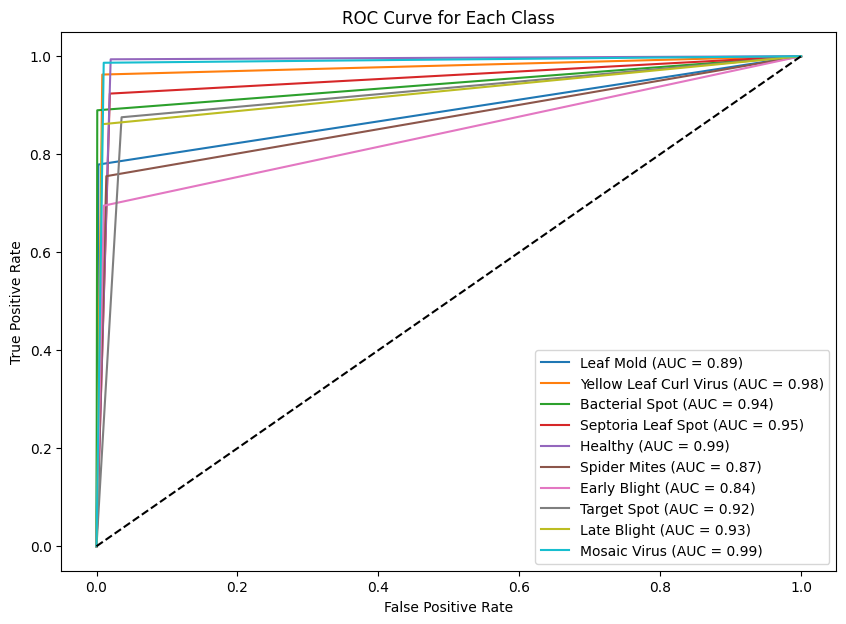

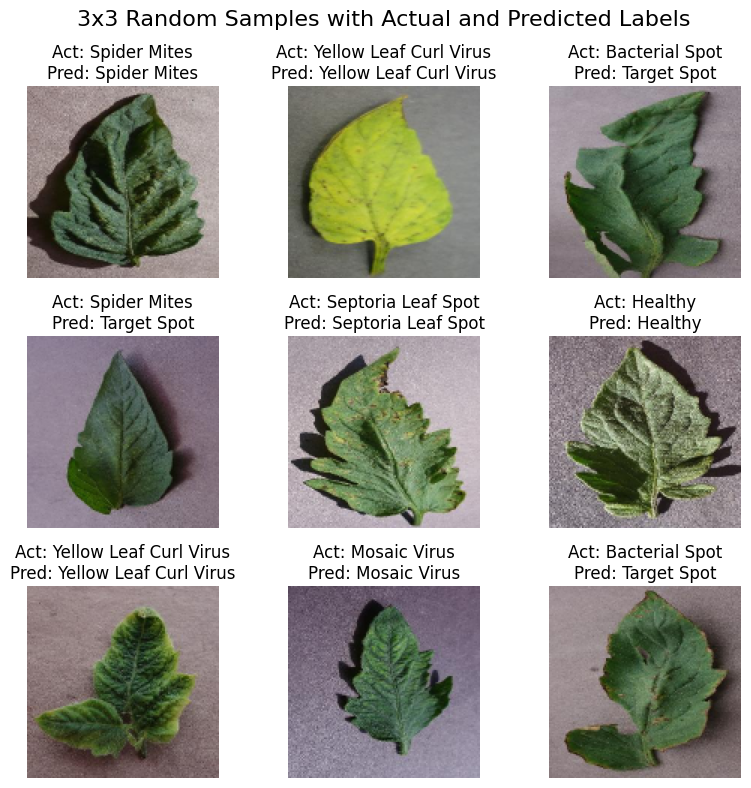

In [13]:
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Generate predictions
evaluate_model(y_test, y_pred, classes, X_test)

# 2) Transfer Learning Models

## a) Mobilenet (Non Trainable)

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model's layers (so they are not trained)
base_model.trainable = False

# Add custom layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Path to save the best model
checkpoint_path = "best_model_TL_NON_Trainable.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [16]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6308 - loss: 1.1068
Epoch 1: val_loss improved from inf to 0.60592, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 58s 123ms/step - accuracy: 0.6313 - loss: 1.1053 - val_accuracy: 0.7809 - val_loss: 0.6059
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8438 - loss: 0.4585

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.60592
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8438 - loss: 0.4585 - val_accuracy: 0.3333 - val_loss: 1.4760
Epoch 3/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8170 - loss: 0.5284
Epoch 3: val_loss improved from 0.60592 to 0.51205, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step - accuracy: 0.8171 - loss: 0.5284 - val_accuracy: 0.8247 - val_loss: 0.5120
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9062 - loss: 0.3337
Epoch 4: val_loss improved from 0.51205 to 0.47035, saving model to best_model_TL_NON_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9062 - loss: 0.3337 - val_accuracy: 0.6667 - val_loss: 0.4703
Epoch 5/10
399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8511 - loss: 0.4349
Epoch 5: val_loss did not improve from 0.47035
400/400 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.8511 - loss: 0.4349 - va

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Accuracy: 0.85
Precision: 0.87
Recall: 0.85
F1 Score: 0.85

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.92      0.82      0.87       190
Yellow Leaf Curl Virus       0.99      0.97      0.98       642
        Bacterial Spot       0.80      0.98      0.88       426
    Septoria Leaf Spot       0.90      0.81      0.85       354
               Healthy       0.98      0.65      0.78       318
          Spider Mites       0.59      0.98      0.74       335
          Early Blight       0.82      0.60      0.69       200
           Target Spot       0.71      0.61      0.66       281
           Late Blight       0.96      0.87      0.91       382
          Mosaic Virus       0.97      0.89      0.93        75

              accuracy                           0.85      3203
             macro avg       0.86      0.82      0.83      3203
          weighted avg       0.87      0.

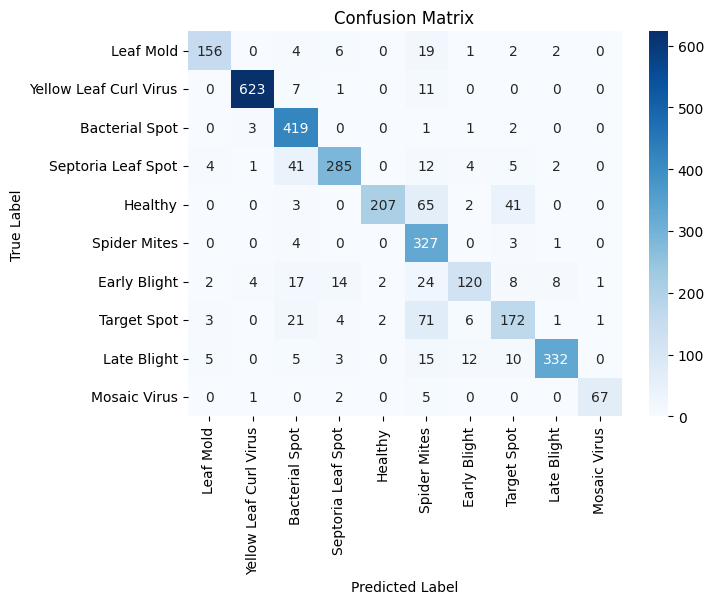

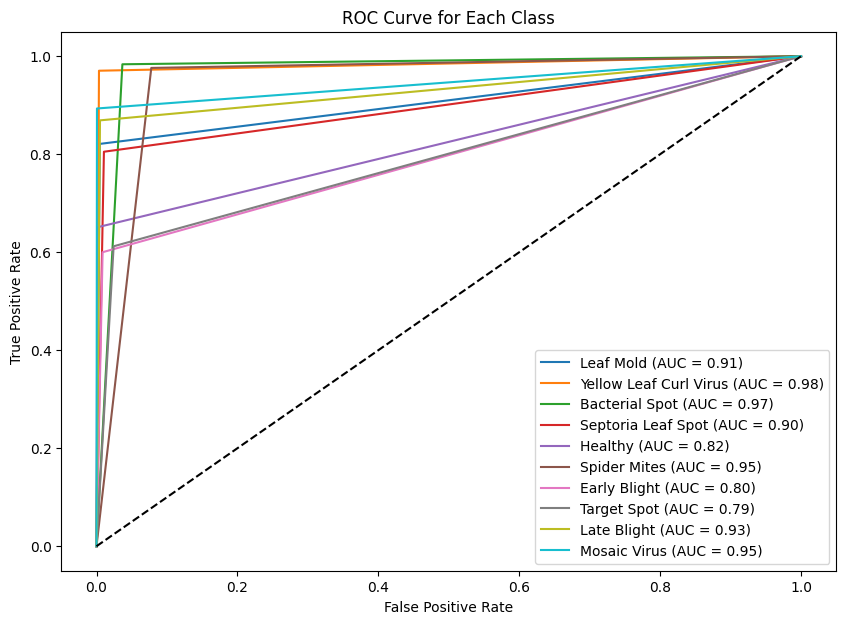

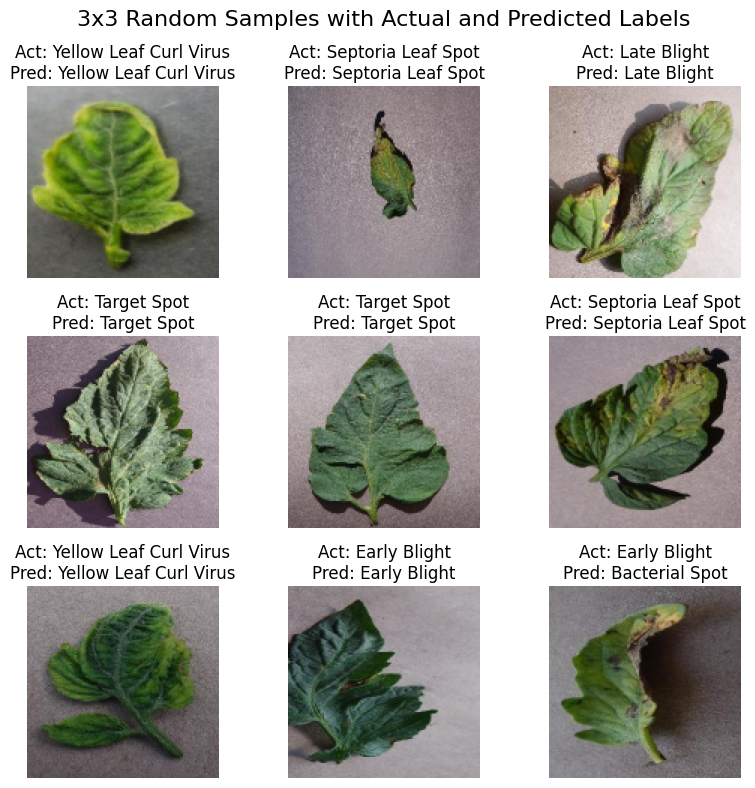

In [17]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Get predicted class indices
evaluate_model(y_test, y_pred, classes, X_test)

### b) Mobilenet (Trainable)

In [18]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model's layers
base_model.trainable = True

# Add custom layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
# Path to save the best model
checkpoint_path = "best_model_TL_Trainable.keras"

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Mode to minimize val_loss
    verbose=1                  # Print saving details
)

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to stop
    mode='min',               # Mode to minimize val_loss
    verbose=1                 # Print stopping details
)

In [20]:
# Train the model
start = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Added callbacks here
)
end = time.time()

# Display training summary
print(f"Training Completed in {end-start} seconds.")

Epoch 1/10
  6/400 ━━━━━━━━━━━━━━━━━━━━ 20:01 3s/step - accuracy: 0.2891 - loss: 2.2126

I0000 00:00:1735822250.452209      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 288 bytes spill stores, 288 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7634 - loss: 0.7689
Epoch 1: val_loss improved from inf to 8.38048, saving model to best_model_TL_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 101s 157ms/step - accuracy: 0.7636 - loss: 0.7683 - val_accuracy: 0.2294 - val_loss: 8.3805
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8750 - loss: 0.7750

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 8.38048 to 8.34000, saving model to best_model_TL_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.7750 - val_accuracy: 0.0000e+00 - val_loss: 8.3400
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9131 - loss: 0.2658
Epoch 3: val_loss did not improve from 8.34000
400/400 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.9131 - loss: 0.2657 - val_accuracy: 0.0234 - val_loss: 20.8659
Epoch 4/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9062 - loss: 0.1474
Epoch 4: val_loss did not improve from 8.34000
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.9062 - loss: 0.1474 - val_accuracy: 0.0000e+00 - val_loss: 22.2352
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9399 - loss: 0.1972
Epoch 5: val_loss improved from 8.34000 to 6.00989, saving model to best_model_TL_Trainable.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.9399 - loss: 0.1972 - 

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
Accuracy: 0.59
Precision: 0.61
Recall: 0.59
F1 Score: 0.56

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.00      0.00      0.00       190
Yellow Leaf Curl Virus       0.96      0.90      0.93       642
        Bacterial Spot       0.00      0.00      0.00       426
    Septoria Leaf Spot       0.31      0.90      0.46       354
               Healthy       0.98      0.81      0.89       318
          Spider Mites       0.83      0.32      0.46       335
          Early Blight       0.83      0.46      0.59       200
           Target Spot       0.43      0.84      0.57       281
           Late Blight       0.86      0.62      0.72       382
          Mosaic Virus       0.29      0.96      0.44        75

              accuracy                           0.59      3203
             macro avg       0.55      0.58      0.51      3203
          weighted avg       0.61      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

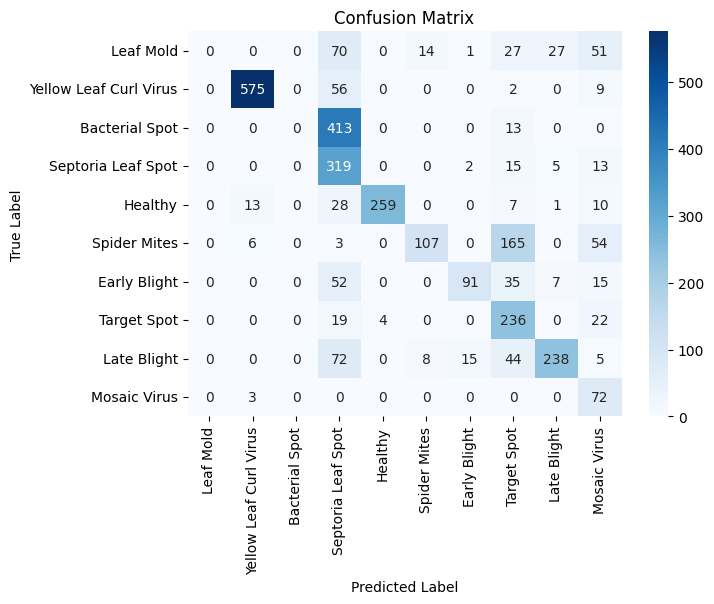

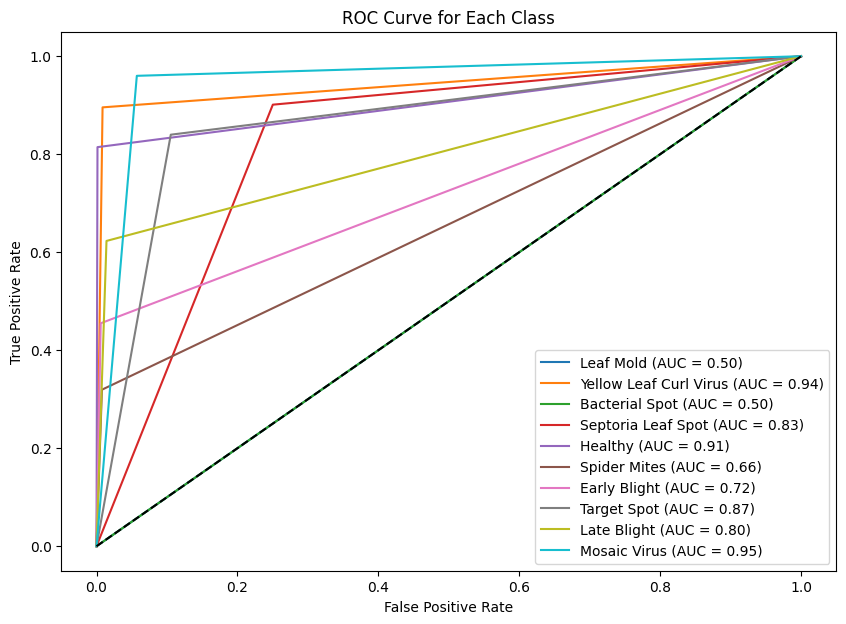

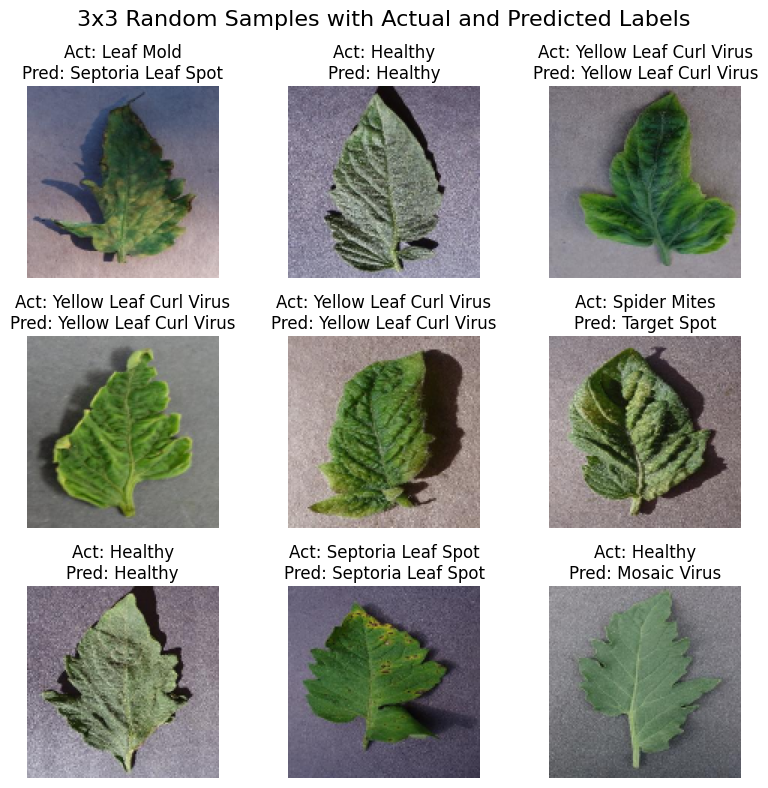

In [21]:
# Generate predictions
y_pred = np.argmax(model.predict(X_test/255.0), axis=1)  # Get predicted class indices
evaluate_model(y_test, y_pred, classes, X_test)

# Hyperparameter Tuning of Best Model (CNN)

In [22]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(DROPOUT_RATIO),
    Dense(len(classes), activation='softmax')  # Output layer with units equal to the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
    metrics=['accuracy']
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Tune the number of Conv2D layers and filters
    for i in range(hp.Int('num_conv_layers', 2, 4)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', values=[32, 64, 128]),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh']),
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3) if i == 0 else None
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Tune the number of dense units
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))

    # Tune dropout rate
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

/tmp/ipykernel_23/4232909160.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [24]:
# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='cnn_tuning'
)

# Search for the best hyperparameters
print("Starting hyperparameter tuning...")
tuner.search(train_generator, epochs=EPOCHS, validation_data=test_generator, steps_per_epoch=len(X_train)//BATCH_SIZE,
             validation_steps=len(X_test)//BATCH_SIZE)

Trial 10 Complete [00h 07m 32s]
val_loss: 0.40574299171566963

Best val_loss So Far: 0.010225231293588877
Total elapsed time: 01h 14m 03s


In [25]:
# Retrieve the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('best_tuned_cnn_model.keras')

# Display the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Conv2D Layers: {best_hps.get('num_conv_layers')}")
for i in range(best_hps.get('num_conv_layers')):
    print(f"Layer {i} Filters: {best_hps.get(f'filters_{i}')}")
    print(f"Layer {i} Kernel Size: {best_hps.get(f'kernel_size_{i}')}")
    print(f"Layer {i} Activation: {best_hps.get(f'activation_{i}')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dense Activation: {best_hps.get('dense_activation')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")

Best Hyperparameters:
Number of Conv2D Layers: 4
Layer 0 Filters: 64
Layer 0 Kernel Size: 3
Layer 0 Activation: relu
Layer 1 Filters: 32
Layer 1 Kernel Size: 3
Layer 1 Activation: relu
Layer 2 Filters: 128
Layer 2 Kernel Size: 3
Layer 2 Activation: tanh
Layer 3 Filters: 32
Layer 3 Kernel Size: 3
Layer 3 Activation: relu
Dense Units: 192
Dense Activation: relu
Dropout Rate: 0.2
Optimizer: adam


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.67
Precision: 0.75
Recall: 0.67
F1 Score: 0.67

Classification Report:
                        precision    recall  f1-score   support

             Leaf Mold       0.77      0.29      0.42       190
Yellow Leaf Curl Virus       0.95      0.91      0.93       642
        Bacterial Spot       0.80      0.88      0.84       426
    Septoria Leaf Spot       0.54      0.61      0.57       354
               Healthy       0.79      0.80      0.79       318
          Spider Mites       0.89      0.24      0.38       335
          Early Blight       0.26      0.57      0.36       200
           Target Spot       0.45      0.68      0.54       281
           Late Blight       0.87      0.54      0.67       382
          Mosaic Virus       0.50      0.88      0.63        75

              accuracy                           0.67      3203
             macro avg       0.68      0.64      0.61      3203
          weighted avg       0.75      0.6

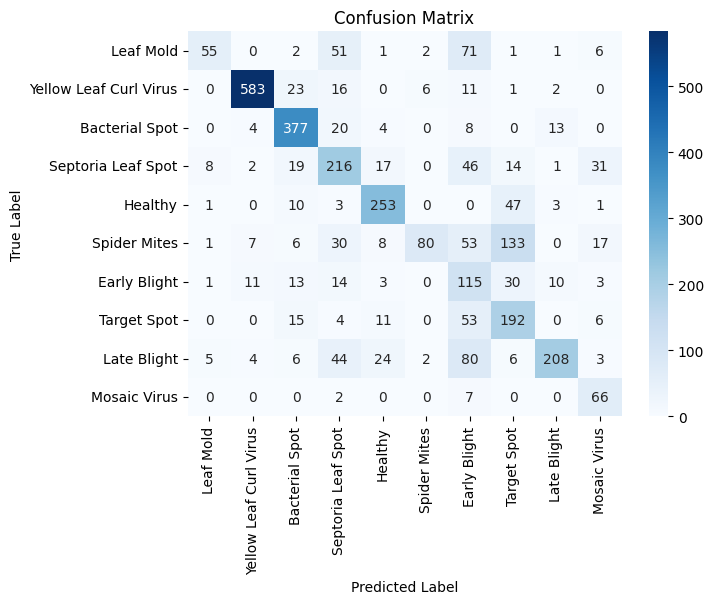

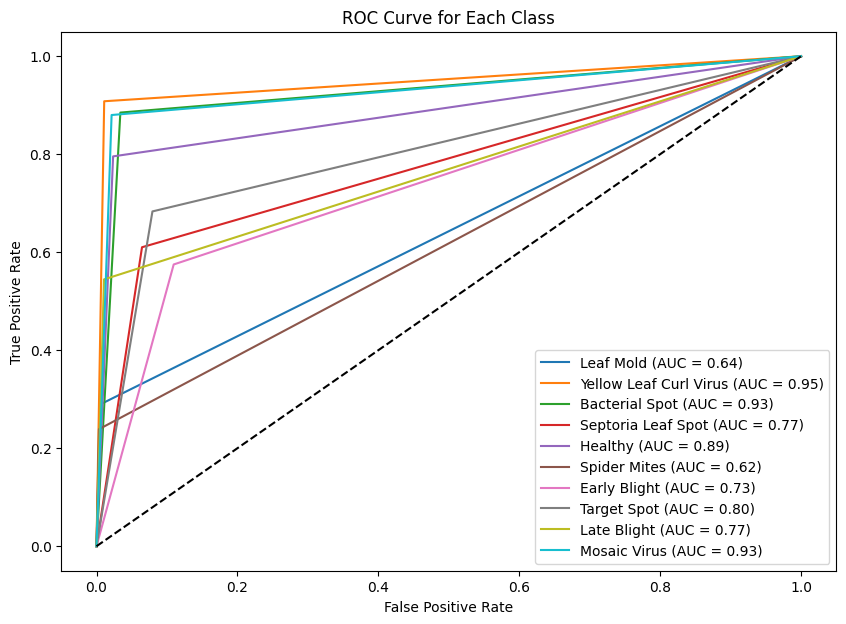

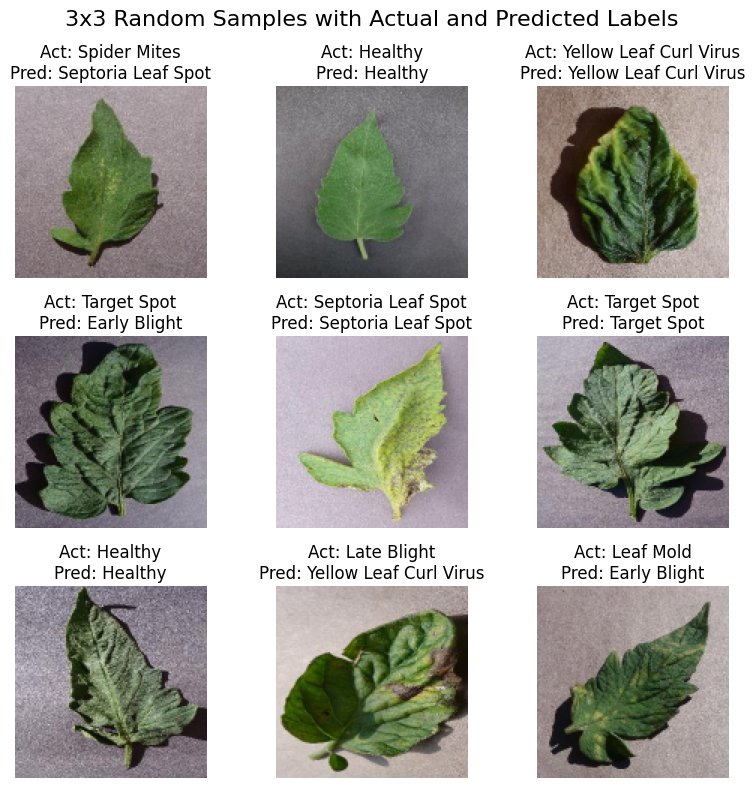

In [26]:
# Generate predictions
y_pred = np.argmax(best_model.predict(X_test/255.0), axis=1)  # Get predicted class indices
evaluate_model(y_test, y_pred, classes, X_test)

In [27]:
# Table of all combinations and their respective results
results = []
for trial in tuner.oracle.get_best_trials(num_trials=10):
    trial_summary = {
        'Trial ID': trial.trial_id,
        'Conv Layers': trial.hyperparameters.get('num_conv_layers'),
        'Dense Units': trial.hyperparameters.get('dense_units'),
        'Dropout Rate': trial.hyperparameters.get('dropout_rate'),
        'Optimizer': trial.hyperparameters.get('optimizer'),
        'Best Val Accuracy': trial.metrics.get_last_value('val_accuracy')
    }
    for i in range(trial_summary['Conv Layers']):
        trial_summary[f'Layer {i} Filters'] = trial.hyperparameters.get(f'filters_{i}')
        trial_summary[f'Layer {i} Kernel Size'] = trial.hyperparameters.get(f'kernel_size_{i}')
        trial_summary[f'Layer {i} Activation'] = trial.hyperparameters.get(f'activation_{i}')
    results.append(trial_summary)

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("Results saved to 'hyperparameter_tuning_results.csv'")
print("\nHyperparameter Tuning Results:")
results_df

Results saved to 'hyperparameter_tuning_results.csv'

Hyperparameter Tuning Results:


Trial ID  Conv Layers  Dense Units  Dropout Rate Optimizer  \
0       02            4          192           0.2      adam   
1       03            3          192           0.4   rmsprop   
2       01            3          256           0.2   rmsprop   
3       06            2          192           0.4       sgd   
4       07            3          128           0.3      adam   
5       00            3          128           0.3   rmsprop   
6       08            3          192           0.2       sgd   
7       09            2          192           0.4   rmsprop   
8       04            3          128           0.2       sgd   
9       05            2          128           0.4       sgd   

   Best Val Accuracy  Layer 0 Filters  Layer 0 Kernel Size Layer 0 Activation  \
0           1.000000               64                    3               relu   
1           1.000000               32                    3               relu   
2           1.000000               64                    3               tanh   
3           1.000000               64                    5               tanh   
4           1.000000              128                    3               relu   
5           0.935781              128                    3               relu   
6           1.000000               32                    5               tanh   
7           1.000000              128                    5               relu   
8           0.833333              128                    3               relu   
9           0.875937               32                    3               tanh   

   Layer 1 Filters  Layer 1 Kernel Size Layer 1 Activation  Layer 2 Filters  \
0               32                    3               relu            128.0   
1              128                    5               relu             64.0   
2               32                    5               tanh             32.0   
3               64                    3               tanh              NaN   
4              128                    5               relu             64.0   
5               64                    3               relu             32.0   
6               64                    5               relu             64.0   
7               64                    5               tanh              NaN   
8              128                    5               relu             32.0   
9              128                    5               relu              NaN   

   Layer 2 Kernel Size Layer 2 Activation  Layer 3 Filters  \
0                  3.0               tanh             32.0   
1                  3.0               tanh              NaN   
2                  5.0               relu              NaN   
3                  NaN                NaN              NaN   
4                  5.0               tanh              NaN   
5                  3.0               relu              NaN   
6                  3.0               relu              NaN   
7                  NaN                NaN              NaN   
8                  3.0               relu              NaN   
9                  NaN                NaN              NaN   

   Layer 3 Kernel Size Layer 3 Activation  
0                  3.0               relu  
1                  NaN                NaN  
2                  NaN                NaN  
3                  NaN                NaN  
4                  NaN                NaN  
5                  NaN                NaN  
6                  NaN                NaN  
7                  NaN                NaN  
8                  NaN                NaN  
9                  NaN                NaN